**15 days ahead solar power production [kWh] forecasting using multivariate and univariate model
****
****1. Random Forrest Model (Multivariate Model)
**

In [34]:
#Importing important libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from keras.callbacks import EarlyStopping
import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

# loading the data
data = pd.read_csv(r'C:\Users\ASEDAI\Downloads\datamv.csv', parse_dates=['time'], index_col='time')
data.head(20)

,output,DNI,DHI,GHI,Temperature,Wind Speed
time,,,,,,
2010-01-01 00:00:00,0.00000,0,0,0,-1.0,3.3
2010-01-01 01:00:00,0.00000,0,0,0,-1.0,3.3
2010-01-01 02:00:00,0.00000,0,0,0,-1.0,3.4
2010-01-01 03:00:00,0.00000,0,0,0,-2.0,3.5
2010-01-01 04:00:00,0.00000,0,0,0,-2.0,3.4
2010-01-01 05:00:00,0.00000,0,0,0,-2.0,3.0
2010-01-01 06:00:00,0.00000,0,0,0,-2.0,2.8
2010-01-01 07:00:00,0.00000,0,0,0,-2.0,2.8
2010-01-01 08:00:00,1.57558,0,32,32,-1.0,3.3


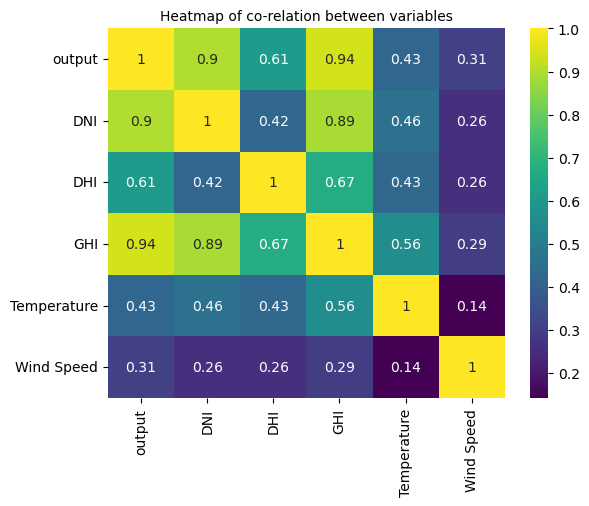

In [35]:
#plotting a correlation heatmap between variables
import seaborn as sns
sns.heatmap(data.corr(),annot=True,cmap='viridis')
plt.title('Heatmap of co-relation between variables',fontsize=10)
plt.show()

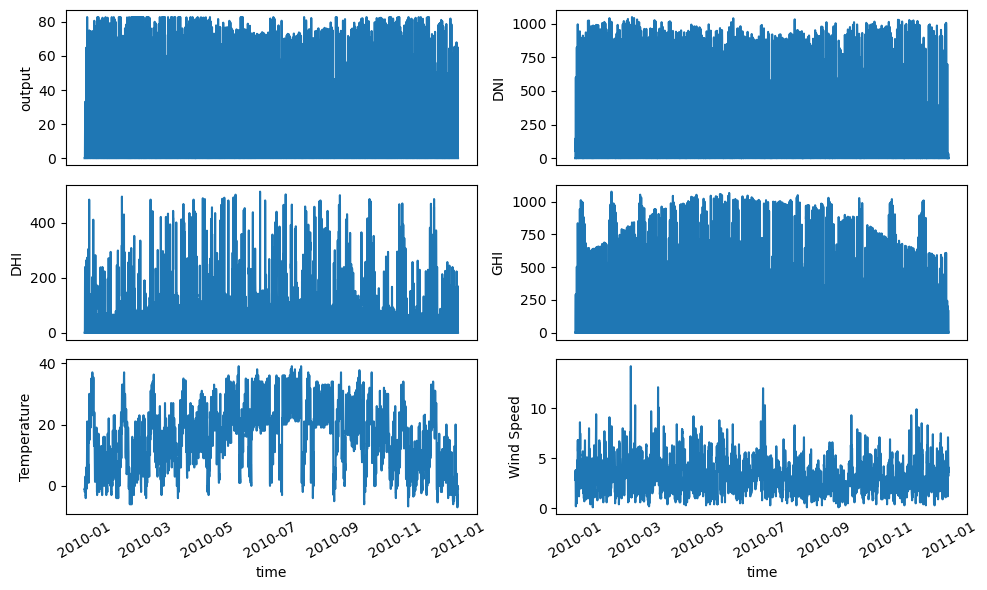

In [36]:
#Plot all the variables used in the study
df_plot = data.copy()
groups = [ 2, 3, 4, 5, 6]
ncols = 2
nrows = int(round(df_plot.shape[1] / ncols, 2))

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(10,6 ))
for i, ax in enumerate(fig.axes):
        sns.lineplot(data = df_plot.iloc[:, i], ax=ax)
        ax.tick_params(axis="x", rotation=30, labelsize=10, length=0)
       
        
fig.tight_layout()
plt.show(groups)

In [37]:
 #defining feature_variable and output variable
feature_variable = ['DNI', 'DHI', 'GHI', 'Temperature', 'Wind Speed']
target_variable = 'output'

training_data = data[:-360]
testing_data = data[-360:]

# Spliting the training_data and testing_data into features and output variable
X_train = training_data[feature_variable]
y_train = training_data[target_variable]
X_test = testing_data[feature_variable]
y_test = testing_data[target_variable]

In [38]:
# Hyperparameter tuning 
# Preprocessing pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
preprocessor = Pipeline([
    ('scaler', StandardScaler())
])
model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

param_grid = {
    'regressor__n_estimators': [50, 75, 100,125, 150],
    'regressor__max_depth': [5, 10, 20],
    'regressor__max_features': ['sqrt', 'log2']
}

grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)
rf_model = grid_search.best_estimator_


In [39]:
# predicting next 15 days/360 hours prediction based on the trainingdata
predictions = rf_model.predict(X_test)

index = pd.date_range(start=data.index[-360], periods=360, freq='H')
next360_predictions = pd.DataFrame(predictions, columns=[target_variable], index=index)


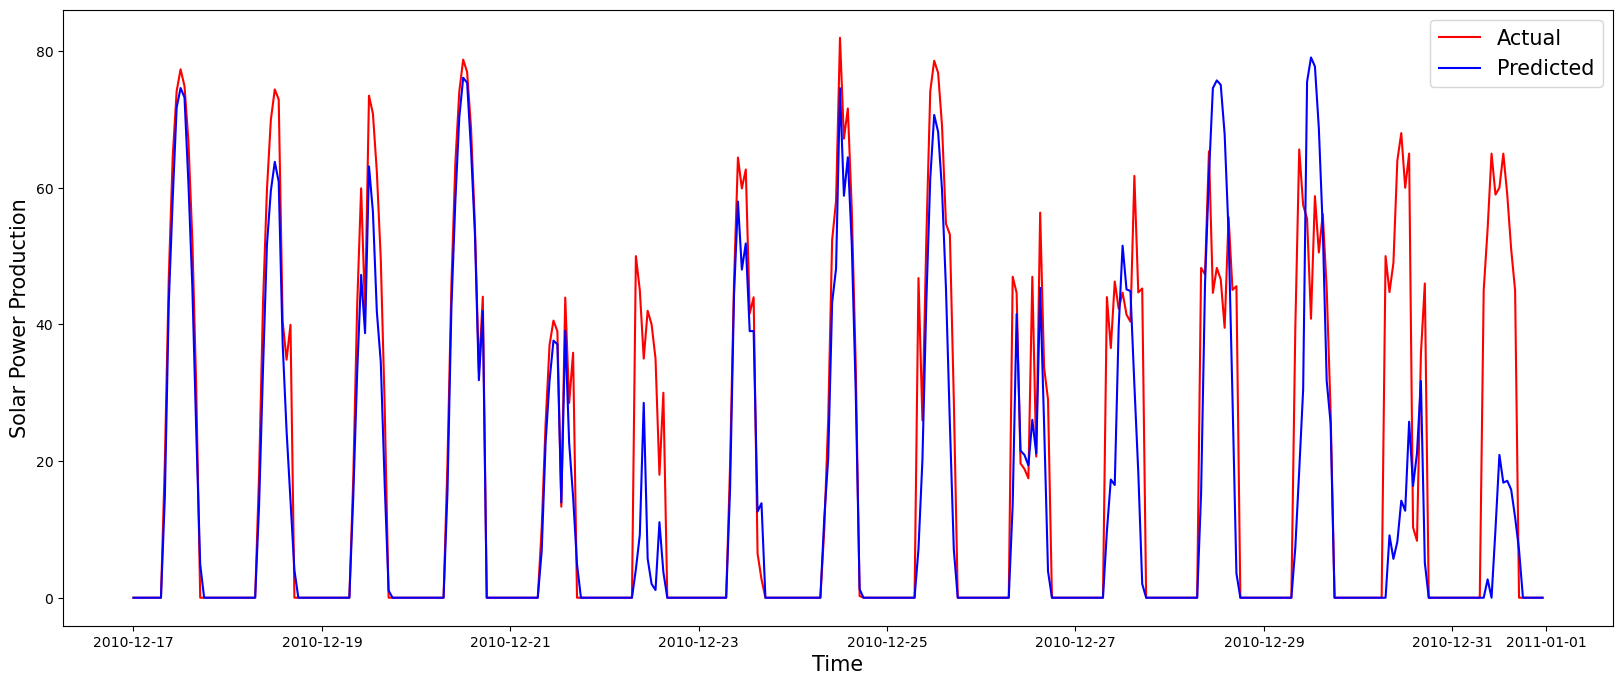

In [40]:
# Plot the actual solar power output versus predicted solar power output values
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 8))
plt.plot(testing_data[target_variable], label='Actual', color='red')
plt.plot(next360_predictions[target_variable], label='Predicted', color='blue')
plt.legend()
plt.xlabel('Time', size=15)
plt.ylabel('Solar Power Production', size=15)
plt.legend(fontsize=15)
plt.show()


In [41]:
# prediction accuracy metrics
rmse = np.sqrt(mean_squared_error(y_test, predictions))
nmae = np.mean(np.abs(predictions - y_test)) / np.mean(y_test)
r_squared = rf_model.score(X_test, y_test)

# Priniting the accuracy result
print(f"RMSE: {rmse:.2f}")
print(f"NMAE: {nmae:.2f}")
#print(f"R-Squared: {r_squared:.2f}")


RMSE: 14.35
NMAE: 0.36


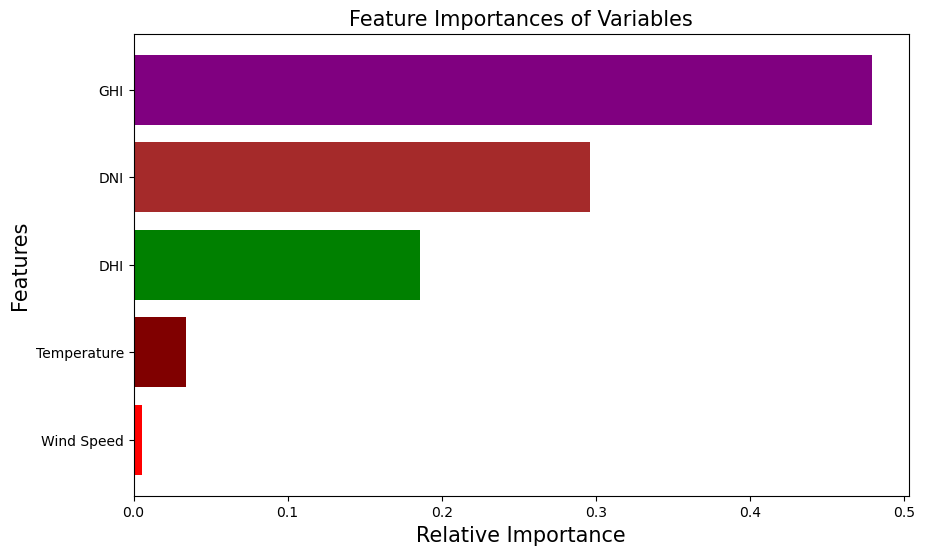

In [9]:
#Looking into the feature importance of the variable
plt.figure(figsize=(10, 6))
importances = rf_model.named_steps['regressor'].feature_importances_
feature_names = feature_variable
sorted_idx = importances.argsort()
colors = ['red', 'maroon', 'green', 'brown', 'purple']
plt.barh(range(len(sorted_idx)), importances[sorted_idx], color=colors)
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.title('Feature Importances of Variables', fontsize=15)
plt.xlabel('Relative Importance', fontsize=15)
plt.ylabel('Features', fontsize=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.show()


**2. Stacked LSTM model (multivariate model)**

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

# Load the data into a Pandas DataFrame
data = pd.read_csv(r'C:\Users\ASEDAI\Downloads\datamv.csv', parse_dates=['time'], index_col='time')

# Define the features and target variable
features = ['DNI', 'DHI', 'GHI', 'Temperature', 'Wind Speed']
target = 'output'

12/12 [==============================] - 1s 2ms/step - loss: 212.8947


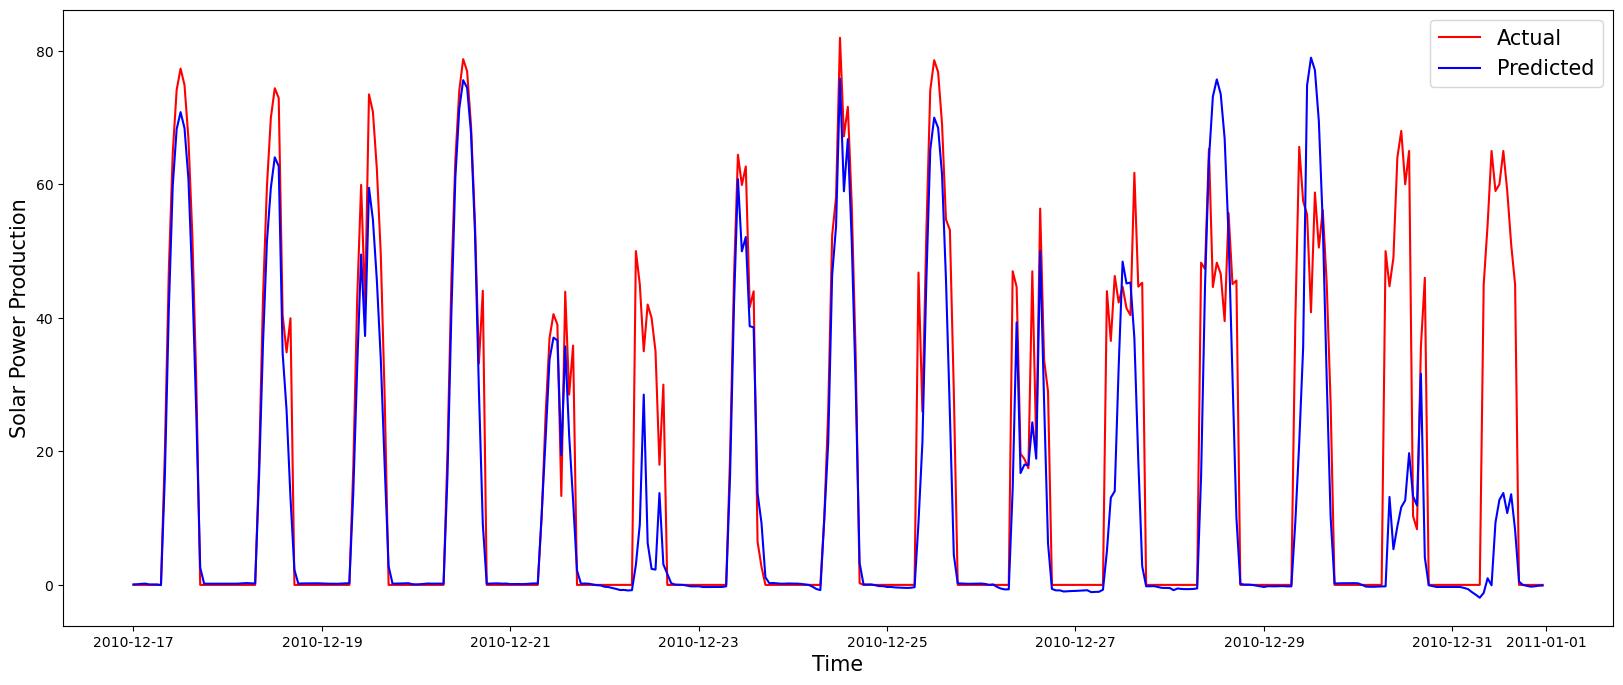

In [11]:

# Split the data into training and testing sets
train_data = data[:-360]
test_data = data[-360:]

# Split the training and testing data into features and target variable
X_train = train_data[features]
y_train = train_data[target]
X_test = test_data[features]
y_test = test_data[target]

# Preprocessing
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Reshape the input data to be 3D for the LSTM model
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Build the LSTM model
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(1, len(features)), return_sequences=True))
model.add(LSTM(32, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Fit the model to the training data
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

# Use the trained model to predict the output values for the last 360 hours
predictions = model.predict(X_test).ravel()

# Create a DataFrame to store the predictions
index = pd.date_range(start=data.index[-360], periods=360, freq='H')
predictions_df = pd.DataFrame(predictions, columns=[target], index=index)

# Evaluate the model on the test set
loss = model.evaluate(X_test, y_test)

# Plot the actual versus predicted values
plt.figure(figsize=(20, 8))
plt.plot(test_data[target], label='Actual', color='red')
plt.plot(predictions_df[target], label='Predicted', color='blue')
plt.legend()
plt.xlabel('Time', size=15)
plt.ylabel('Solar Power Production', size=15)
plt.legend(fontsize=15)

plt.show()


In [29]:

# Calculate performance metrics
rmse = np.sqrt(mean_squared_error(y_test, predictions))
nmae = np.mean(np.abs(predictions - y_test)) / np.mean(y_test)
r_squared = 1 - (np.sum((y_test - predictions)**2) / np.sum((y_test - np.mean(y_test))**2)) 
#Print the performance metrics
print(f"RMSE: {rmse:.2f}")
print(f"NMAE: {nmae:.2f}")
#print(f"R-Squared: {r_squared:.2f}")



RMSE: 35.71
NMAE: -252.19


**3. Stacked GRU model (multivariate model)**

12/12 [==============================] - 1s 2ms/step - loss: 207.6269


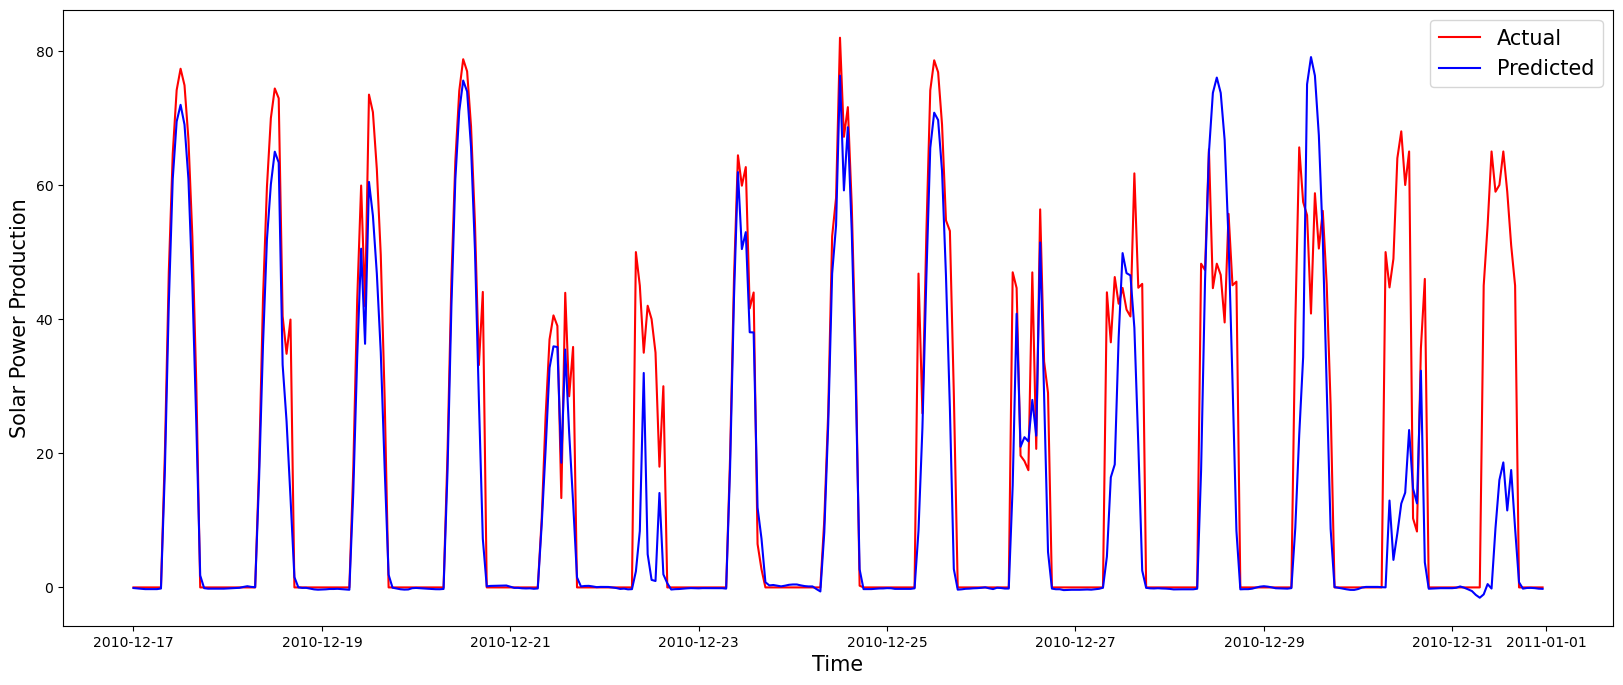

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU

# Load the data into a Pandas DataFrame
data = pd.read_csv(r'C:\Users\ASEDAI\Downloads\datamv.csv', parse_dates=['time'], index_col='time')

# Define the features and target variable
features = ['DNI', 'DHI', 'GHI', 'Temperature', 'Wind Speed']
target = 'output'

# Split the data into training and testing sets
train_data = data[:-360]
test_data = data[-360:]

# Split the training and testing data into features and target variable
X_train = train_data[features]
y_train = train_data[target]
X_test = test_data[features]
y_test = test_data[target]

# Preprocessing
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Reshape the input data to be 3D for the GRU model
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Build the GRU model
model = Sequential()
model.add(GRU(32, activation='relu', input_shape=(1, len(features)), return_sequences=True))
model.add(GRU(32, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Fit the model to the training data
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

# Use the trained model to predict the output values for the last 360 hours
predictions = model.predict(X_test).ravel()

# Create a DataFrame to store the predictions
index = pd.date_range(start=data.index[-360], periods=360, freq='H')
predictions_df = pd.DataFrame(predictions, columns=[target], index=index)

# Evaluate the model on the test set
loss = model.evaluate(X_test, y_test)

# Plot the actual versus predicted values
plt.figure(figsize=(20, 8))
plt.plot(test_data[target], label='Actual', color='red')
plt.plot(predictions_df[target], label='Predicted', color='blue')
plt.legend()
plt.xlabel('Time', size=15)
plt.ylabel('Solar Power Production', size=15)
plt.legend(fontsize=15)

plt.show()



In [14]:
# Calculate performance metrics
rmse = np.sqrt(mean_squared_error(y_test, predictions))
nmae = np.mean(np.abs(predictions - y_test)) / np.mean(y_test)
r_squared = 1 - (np.sum((y_test - predictions)**2) / np.sum((y_test - np.mean(y_test))**2))
# Print the performance metrics
print(f"RMSE: {rmse:.2f}")
print(f"NMAE: {nmae:.2f}")
print(f"R-Squared: {r_squared:.2f}")

RMSE: 14.41
NMAE: 0.36
R-Squared: 0.68


**4. Encoder-Decoder LSTM**

12/12 [==============================] - 1s 5ms/step - loss: 206.9058


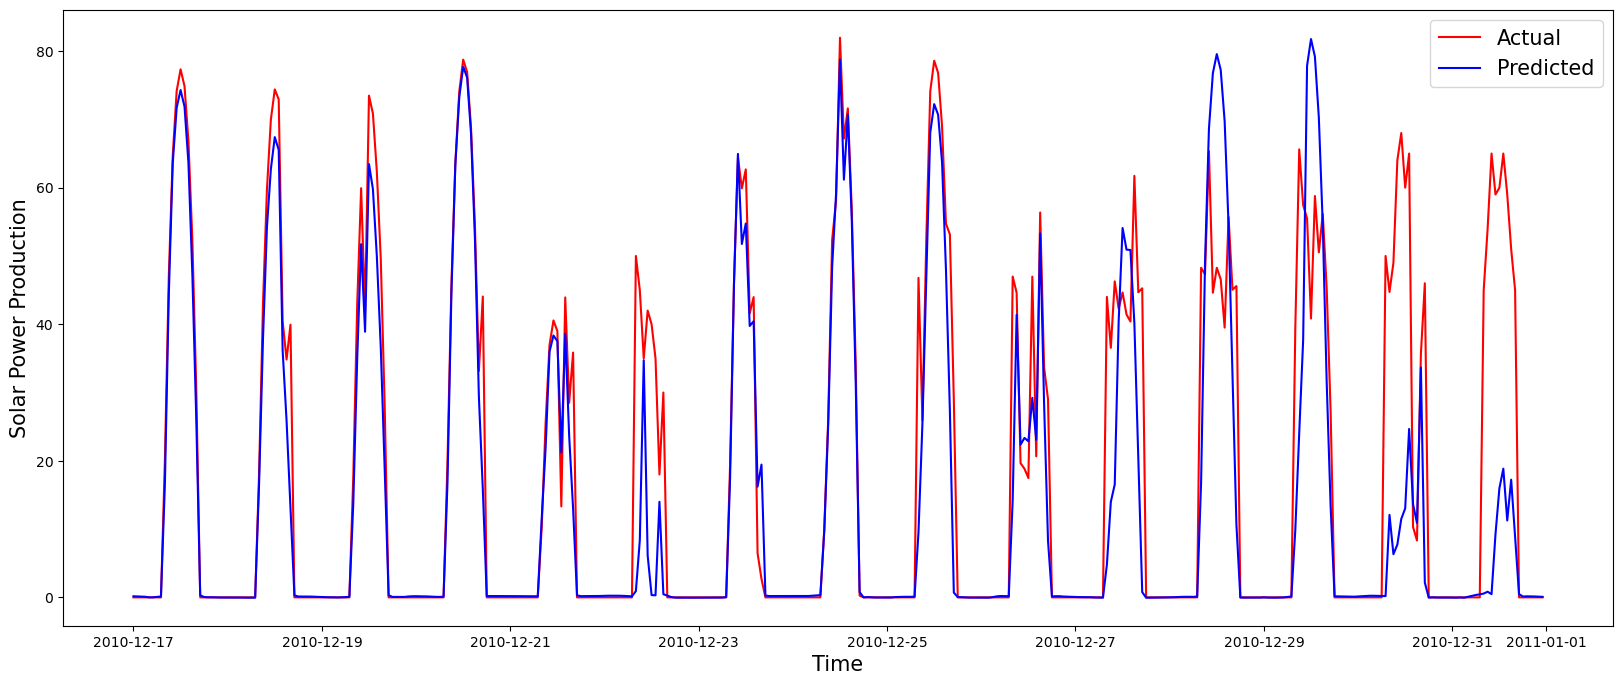

RMSE: 14.37
NMAE: 0.34
R-Squared: 0.68


In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, RepeatVector, TimeDistributed

# Load the data into a Pandas DataFrame
data = pd.read_csv(r'C:\Users\ASEDAI\Downloads\datamv.csv', parse_dates=['time'], index_col='time')

# Define the features and target variable
features = ['DNI', 'DHI', 'GHI', 'Temperature', 'Wind Speed']
target = 'output'

# Split the data into training and testing sets
train_data = data[:-360]
test_data = data[-360:]

# Split the training and testing data into features and target variable
X_train = train_data[features]
y_train = train_data[target]
X_test = test_data[features]
y_test = test_data[target]

# Preprocessing
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Reshape the input data to be 3D for the LSTM model
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Build the Encoder-Decoder LSTM model
model = Sequential()
model.add(LSTM(32, activation='relu', input_shape=(1, len(features))))
model.add(RepeatVector(24))
model.add(LSTM(32, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(1)))
model.compile(optimizer='adam', loss='mse')

# Fit the model to the training data
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

# Use the trained model to predict the output values for the last 360 hours
predictions = model.predict(X_test)

# Reshape the predictions array
predictions = np.mean(predictions, axis=1)

# Create a DataFrame to store the predictions
index = pd.date_range(start=data.index[-360], periods=360, freq='H')
predictions_df = pd.DataFrame(predictions, columns=[target], index=index)

# Evaluate the model on the test set
loss = model.evaluate(X_test, y_test)

# Plot the actual versus predicted values
plt.figure(figsize=(20, 8))
plt.plot(test_data[target], label='Actual', color='red')
plt.plot(predictions_df[target], label='Predicted', color='blue')
plt.legend()
plt.xlabel('Time', size=15)
plt.ylabel('Solar Power Production', size=15)
plt.legend(fontsize=15)

plt.show()
# Calculate performance metrics
rmse = np.sqrt(mean_squared_error(y_test, predictions))
nmae = np.mean(np.abs(predictions.flatten() - y_test.values)) / np.mean(y_test)
r_squared = 1 - (np.sum((y_test.values.flatten() - predictions.flatten())**2) / np.sum((y_test.values.flatten() - np.mean(y_test))**2))

# Print the performance metrics
print(f"RMSE: {rmse:.2f}")
print(f"NMAE: {nmae:.2f}")
print(f"R-Squared: {r_squared:.2f}")





**4. ARIMA Model  (Univariate Model)**

In [16]:
# Import Basic Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# preprocessing data

df = pd.read_csv(r"C:\Users\ASEDAI\Downloads\datamv.csv",usecols = [0,1], index_col = 0, parse_dates=[0], dayfirst=True)
df

,output
time,
2010-01-01 00:00:00,0.0
2010-01-01 01:00:00,0.0
2010-01-01 02:00:00,0.0
2010-01-01 03:00:00,0.0
2010-01-01 04:00:00,0.0
...,...
2010-12-31 19:00:00,0.0
2010-12-31 20:00:00,0.0
2010-12-31 21:00:00,0.0


time
2010-12-17 00:00:00    0.0
2010-12-17 01:00:00    0.0
2010-12-17 02:00:00    0.0
2010-12-17 03:00:00    0.0
2010-12-17 04:00:00    0.0
                      ... 
2010-12-31 19:00:00    0.0
2010-12-31 20:00:00    0.0
2010-12-31 21:00:00    0.0
2010-12-31 22:00:00    0.0
2010-12-31 23:00:00    0.0
Name: output, Length: 360, dtype: float64


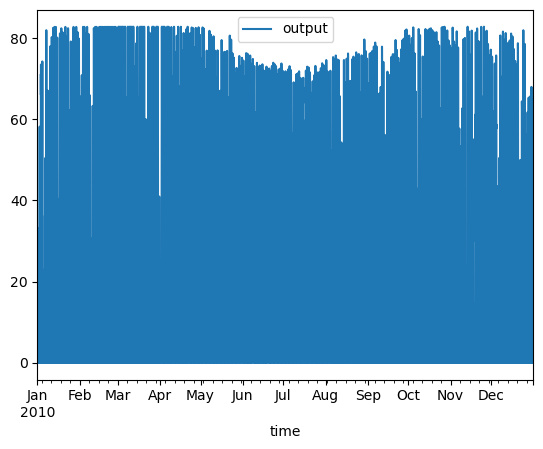

In [17]:
#TRAINING/TESTING DATA
#df1.index = pd.DatetimeIndex(df1.index)

#df.to_csv('lubbock solar data')

#df1.dropna(inplace = True)

df = pd.DataFrame(df['output'])

df.plot()
df

train = df.iloc[:8400,0]
test = df.iloc[8400:,0]
print(test)

<AxesSubplot:xlabel='time', ylabel='Resid'>

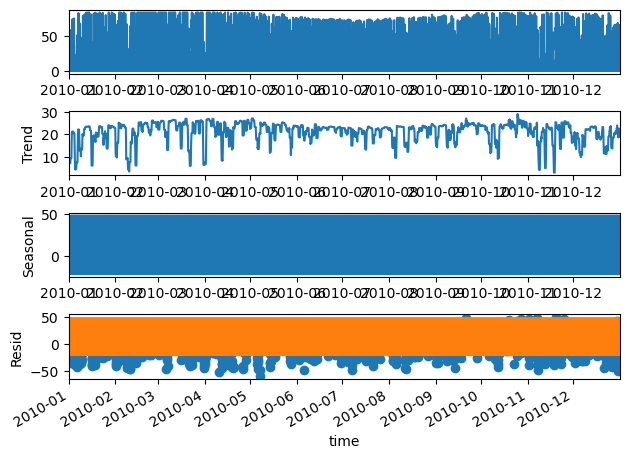

In [18]:
# Decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
Decomp_results = seasonal_decompose(df)

Decomp_results.plot()

Decomp_results.seasonal.plot()

C:\Users\ASEDAI\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=64837.206, Time=13.67 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=83469.536, Time=0.28 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=68189.189, Time=0.97 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=75361.998, Time=2.57 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=87294.797, Time=0.14 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=66450.474, Time=4.58 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=64841.698, Time=7.03 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=64841.915, Time=7.98 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=64739.208, Time=18.87 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=66111.193, Time=8.14 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=64820.642, Time=21.89 sec
 ARIMA(2,0,4)(0,0,0)[0] intercept   : AIC=64728.981, Time=21.23 sec
 ARIMA(1,0,4)(0,0,0)[0] intercept   : AIC=65923.978, Time=10.47 sec
 ARIMA(3,0,4)(0,0,0)[0] intercept   : AIC=64735.075, Time=23.26 sec
 ARIMA(2,0,5)

ARIMA(order=(3, 0, 5), scoring_args={}, suppress_warnings=True)

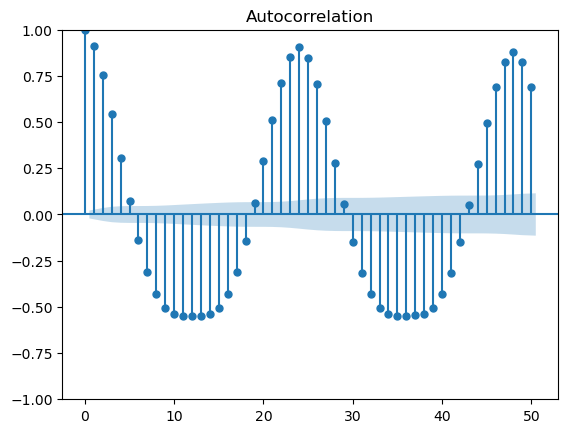

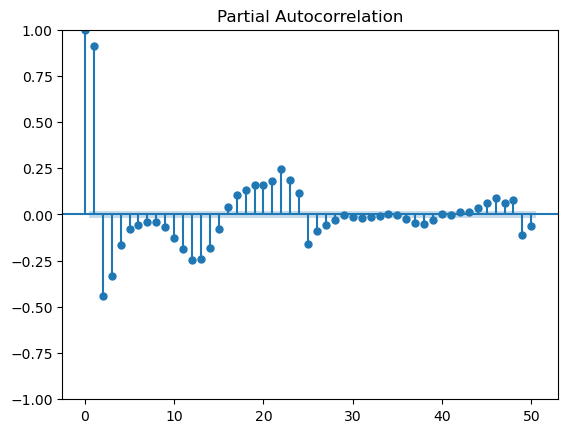

In [19]:
 #Finding the Parameters (p,d,q)

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(train, lags=50)

plot_pacf(train, lags=50)


from pmdarima import auto_arima

auto_arima(df, trace = True)

In [20]:
# Developing ARIMA Model
from statsmodels.tsa.arima.model import ARIMA

A_Model = ARIMA(train, order = (3,0,5))

predictor = A_Model.fit()

predictor.summary()
print(predictor.summary())

Predicted_results = predictor.predict(start = len(train), end = len(train)+len(test) - 1, typ = 'levels')

C:\Users\ASEDAI\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
C:\Users\ASEDAI\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
C:\Users\ASEDAI\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
C:\Users\ASEDAI\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                 output   No. Observations:                 8400
Model:                 ARIMA(3, 0, 5)   Log Likelihood              -30897.413
Date:                Tue, 11 Apr 2023   AIC                          61814.827
Time:                        00:30:16   BIC                          61885.187
Sample:                    01-01-2010   HQIC                         61838.851
                         - 12-16-2010                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         21.1037      0.296     71.361      0.000      20.524      21.683
ar.L1          1.2647      1.504      0.841      0.400      -1.683       4.212
ar.L2          0.1228      2.749      0.045      0.9

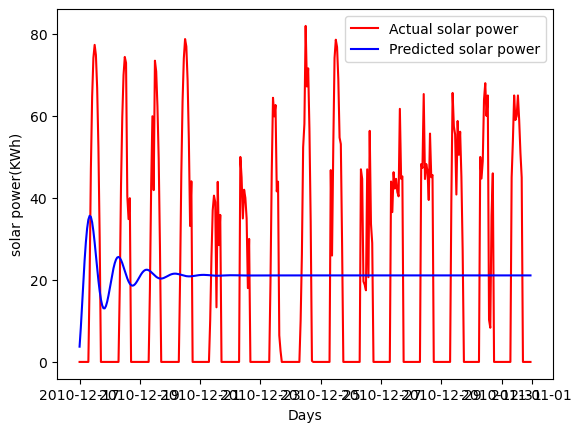

In [21]:
#Plotting result

plt.plot(test, color = 'red', label = 'Actual solar power')
plt.plot(Predicted_results, color = 'blue', label = 'Predicted solar power')
plt.xlabel ('Days')
plt.ylabel('solar power(KWh)')
plt.legend()
plt.show()

In [22]:

nmae = np.mean(np.abs(Predicted_results - test)) / np.mean(test)
r_squared = 1 - (np.sum((test - Predicted_results)**2) / np.sum((test - np.mean(test))**2))

# Print the performance metrics

print(f"NMAE: {nmae:.2f}")
print(f"R-Squared: {r_squared:.2f}")

NMAE: 1.26
R-Squared: 0.01


**5. SVR Model (Univariate Model)**

RMSE: 25.74
NMAE: 1.29
R-Squared: -0.02


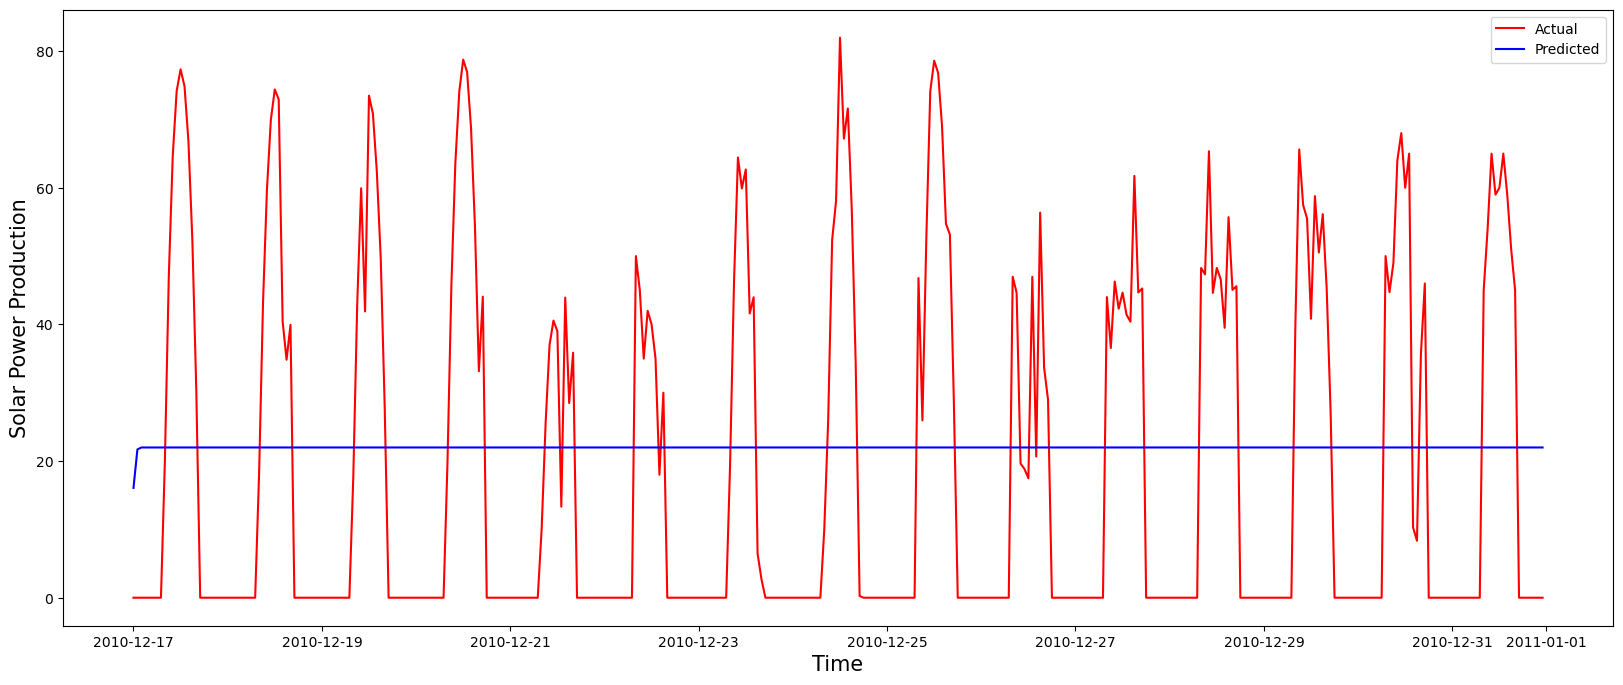

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

# Load the data into a Pandas DataFrame
df = pd.read_csv(r'C:\Users\ASEDAI\Downloads\datamv.csv', parse_dates=['time'], index_col='time')

# Define the target variable
target = 'output'

# Split the data into training and testing sets
train_data = df[:-360]
test_data = df[-360:]

# Split the training and testing data into features and target variable
y_train = train_data[target]
y_test = test_data[target]

# Preprocessing
scaler = StandardScaler()
y_train = scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test = scaler.transform(y_test.values.reshape(-1, 1))

# Build the SVR model
model = SVR(kernel='rbf', C=50, gamma='auto', epsilon=.1)

# Fit the model to the training data
model.fit(np.arange(len(y_train)).reshape(-1,1), y_train.ravel())

# Use the trained model to predict the output values for the last 360 hours
predictions = scaler.inverse_transform(model.predict(np.arange(len(y_train), len(y_train)+len(y_test)).reshape(-1,1)).reshape(-1, 1))

# Create a DataFrame to store the predictions
index = pd.date_range(start=data.index[-360], periods=360, freq='H')
predictions_df = pd.DataFrame(predictions, columns=[target], index=index)


# Calculate performance metrics
rmse = np.sqrt(mean_squared_error(test_data[target], predictions_df[target]))
nmae = np.mean(np.abs(predictions_df[target] - test_data[target])) / np.mean(test_data[target])
r_squared = 1 - (np.sum((test_data[target] - predictions_df[target])**2) / np.sum((test_data[target] - np.mean(test_data[target]))**2))

# Print the performance metrics
print(f"RMSE: {rmse:.2f}")
print(f"NMAE: {nmae:.2f}")
print(f"R-Squared: {r_squared:.2f}")

# Plot the actual versus predicted values
plt.figure(figsize=(20, 8))
plt.plot(test_data[target], label='Actual', color='red')
plt.plot(predictions_df[target], label='Predicted', color='blue')
plt.legend()
plt.xlabel('Time', size=15)
plt.ylabel('Solar Power Production', size=15)
plt.show()


**6. LSTM Model (Univariate Model)
**       (tuning features variable to see how it effect the model performance)

12/12 [==============================] - 0s 2ms/step - loss: 269.0988


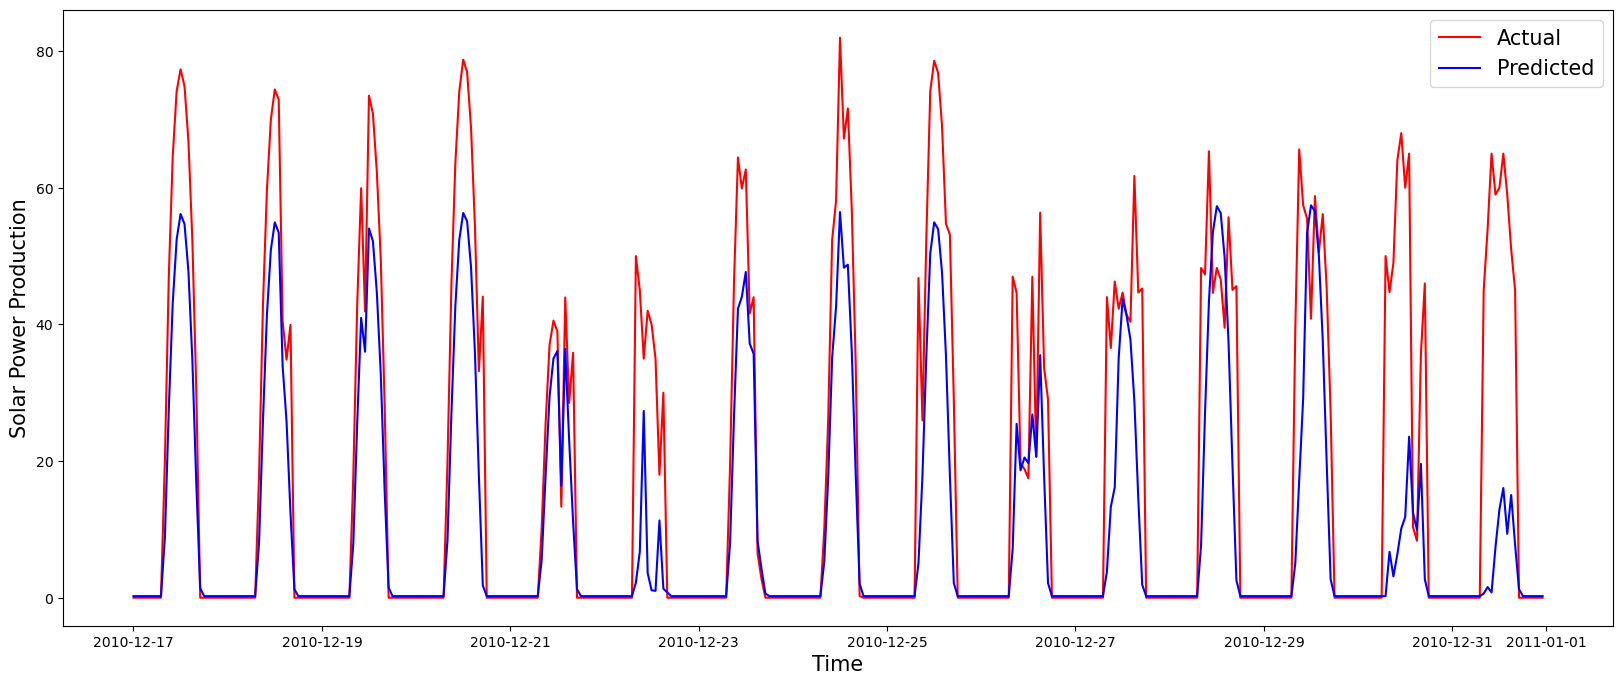

RMSE: 16.40
NMAE: 0.47
R-Squared: 0.59


In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

# Load the data into a Pandas DataFrame
data = pd.read_csv(r'C:\Users\ASEDAI\Downloads\datamv.csv', parse_dates=['time'], index_col='time')

# Define the features and target variable
features = ['GHI']
target = 'output'

# Split the data into training and testing sets
train_data = data[:-360]
test_data = data[-360:]

# Split the training and testing data into features and target variable
X_train = train_data[features]
y_train = train_data[target]
X_test = test_data[features]
y_test = test_data[target]

# Preprocessing
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Reshape the input data to be 3D for the LSTM model
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Build the LSTM model
model = Sequential()
model.add(LSTM(32, activation='relu', input_shape=(1, len(features))))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Fit the model to the training data
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

# Use the trained model to predict the output values for the last 360 hours
predictions = model.predict(X_test)

# Create a DataFrame to store the predictions
index = pd.date_range(start=data.index[-360], periods=360, freq='H')
predictions_df = pd.DataFrame(predictions, columns=[target], index=index)

# Evaluate the model on the test set
loss = model.evaluate(X_test, y_test)

# Plot the actual versus predicted values
plt.figure(figsize=(20, 8))
plt.plot(test_data[target], label='Actual', color='red')
plt.plot(predictions_df[target], label='Predicted', color='blue')
plt.legend()
plt.xlabel('Time', size=15)
plt.ylabel('Solar Power Production', size=15)
plt.legend(fontsize=15)

plt.show()

# Calculate performance metrics
rmse = np.sqrt(mean_squared_error(y_test, predictions))
nmae = np.mean(np.abs(predictions.flatten() - y_test.values)) / np.mean(y_test)
r_squared = 1 - (np.sum((y_test.values.flatten() - predictions.flatten())**2) / np.sum((y_test.values.flatten() - np.mean(y_test))**2))

# Print the performance metrics
print(f"RMSE: {rmse:.2f}")
print(f"NMAE: {nmae:.2f}")
print(f"R-Squared: {r_squared:.2f}")
